In [33]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import mlflow
import warnings


In [34]:
RANDOM_SEED = 42

# current_dir = os.path.dirname(os.path.realpath(__file__))
current_dir = os.getcwd()
data_fldr = os.path.join(current_dir, "..", "data")
out_dir = os.path.join(current_dir, "..", "data", "output")

coe_df = pd.read_excel(os.path.join(data_fldr, "COE_Export.xlsx"), sheet_name="Quarterly")

In [35]:
coe_df

,Month of Bidding Exercise,Bidding,Category,Statistic,Value,Year
0,2024-05-01,1,A,Quota Premium,93604,2024
1,2024-05-01,1,B,Quota Premium,105002,2024
2,2024-05-01,1,C,Quota Premium,70001,2024
3,2024-05-01,1,D,Quota Premium,9503,2024
4,2024-05-01,1,E,Quota Premium,104689,2024
...,...,...,...,...,...,...
2895,2005-08-15,2,E,Quota Premium,16296,2005
2896,2005-09-15,2,E,Quota Premium,15699,2005
2897,2005-10-15,2,E,Quota Premium,14503,2005
2898,2005-11-15,2,E,Quota Premium,14505,2005


In [36]:
coe_df_a = coe_df.loc[coe_df['Category'] == "A", :].sort_values(by='Month of Bidding Exercise')
coe_df_a

,Month of Bidding Exercise,Bidding,Category,Statistic,Value,Year
1748,2000-01-01,1,A,Quota Premium,43802,2000
1808,2000-01-15,2,A,Quota Premium,43802,2000
1749,2000-02-01,1,A,Quota Premium,43998,2000
1809,2000-02-15,2,A,Quota Premium,43998,2000
1750,2000-03-01,1,A,Quota Premium,39300,2000
...,...,...,...,...,...,...
860,2024-03-15,2,A,Quota Premium,85489,2024
5,2024-04-01,1,A,Quota Premium,89000,2024
855,2024-04-15,2,A,Quota Premium,94010,2024
0,2024-05-01,1,A,Quota Premium,93604,2024


In [37]:
# Split data into train and test sets
coe_df_set = coe_df_a.loc[:, ['Month of Bidding Exercise', 'Value']]
coe_df_set.set_index('Month of Bidding Exercise', inplace=True)
train_size = int(len(coe_df_set) * 0.90)
train, test = coe_df_set.iloc[:train_size], coe_df_set.iloc[train_size:]

train

,Value
Month of Bidding Exercise,
2000-01-01,43802
2000-01-15,43802
2000-02-01,43998
2000-02-15,43998
2000-03-01,39300
...,...
2021-10-15,52709
2021-11-01,53709
2021-11-15,55001


In [49]:
def arima_grid_search(train):
    # Define the range of p, d, and q parameters for non-seasonal components
    p = d = q = range(0, 3)
    non_seasonal_pdq = [(x[0], x[1], x[2]) for x in list(product(p, d, q))]
    # Define the range of P, D, and Q parameters for seasonal components

    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(product(p, d, q))]
    # p = d = q = 1

    best_aic = np.inf
    best_params = None
    best_seasonal_params = None
    best_model = None
    i = 1
    for params in non_seasonal_pdq:
        # for seasonal_params in seasonal_pdq:
            # print(f"Using Params = ({params}) and Seasonal Params = {seasonal_params}")
            print(f"Iteration = {i} / {3**6} : Using Non-Seasonal Params = ({params}) Seasonal Params = (2,2,2,24)")
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = SARIMAX(train, order=params, seasonal_order=(2,2,2,24), enforce_stationarity=False, enforce_invertibility=False)
                    results = model.fit()
                    
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = params
                    best_seasonal_params = (2,2,2,24)
                    best_model = results
            except Exception as e:
                print(f"Failed with {e}")
                continue
        
            i += 1
        
    return best_model, best_params, best_seasonal_params


In [50]:
best_model, best_params, best_seasonal_params = arima_grid_search(train)
print(f"Best Params = {best_params} ; Best Seasonal Params = {best_seasonal_params}")

Iteration = 1 / 729 : Using Non-Seasonal Params = ((0, 0, 0)) Seasonal Params = (2,2,2,24)
Iteration = 2 / 729 : Using Non-Seasonal Params = ((0, 0, 1)) Seasonal Params = (2,2,2,24)
Iteration = 3 / 729 : Using Non-Seasonal Params = ((0, 0, 2)) Seasonal Params = (2,2,2,24)
Iteration = 4 / 729 : Using Non-Seasonal Params = ((0, 1, 0)) Seasonal Params = (2,2,2,24)
Iteration = 5 / 729 : Using Non-Seasonal Params = ((0, 1, 1)) Seasonal Params = (2,2,2,24)
Iteration = 6 / 729 : Using Non-Seasonal Params = ((0, 1, 2)) Seasonal Params = (2,2,2,24)
Iteration = 7 / 729 : Using Non-Seasonal Params = ((0, 2, 0)) Seasonal Params = (2,2,2,24)
Iteration = 8 / 729 : Using Non-Seasonal Params = ((0, 2, 1)) Seasonal Params = (2,2,2,24)
Iteration = 9 / 729 : Using Non-Seasonal Params = ((0, 2, 2)) Seasonal Params = (2,2,2,24)
Iteration = 10 / 729 : Using Non-Seasonal Params = ((1, 0, 0)) Seasonal Params = (2,2,2,24)
Iteration = 11 / 729 : Using Non-Seasonal Params = ((1, 0, 1)) Seasonal Params = (2,2,2,2

Best Params = (0,1,2) ; Best Seasonal Params = (2, 2, 2, 24)

In [ ]:
manual_model = SARIMAX(train, order=(1,0,1), seasonal_order=best_seasonal_params, enforce_stationarity=False, enforce_invertibility=False).fit()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                  522
Model:             SARIMAX(0, 1, 2)x(2, 2, 2, 24)   Log Likelihood               -4057.809
Date:                            Sun, 16 Jun 2024   AIC                           8129.618
Time:                                    16:34:20   BIC                           8157.933
Sample:                                         0   HQIC                          8140.808
                                            - 522                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0746      0.042     -1.778      0.075      -0.157       0.008
ma.L2         -0.0570      0.043   

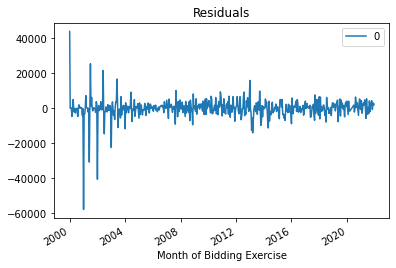

In [51]:
# Summary of the model
print(best_model.summary())
# Plot the residuals
residuals = pd.DataFrame(best_model.resid)
residuals.plot(title='Residuals')
plt.show()

In [52]:
# Assuming you have new_data or test data for prediction
# For example purposes, let's generate forecasts for the next 24 steps (adjust as needed)
forecast_steps = len(test)+2
forecast = best_model.forecast(steps=forecast_steps)

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [53]:
print(forecast)
print(pd.date_range(start = train.index[-1], periods=forecast_steps, freq="SMS"))

522    59464.672827
523    58878.668160
524    59387.573553
525    59226.023845
526    58476.133453
527    58896.131348
528    58836.245559
529    59614.279348
530    57238.815923
531    55959.880355
532    58273.388426
533    57803.275390
534    57924.412038
535    59292.827756
536    59642.321963
537    58102.948866
538    60326.509628
539    59505.514373
540    56966.568317
541    59581.723591
542    61377.188475
543    61441.132873
544    61787.904289
545    62316.985164
546    63199.970783
547    63011.003754
548    63224.453668
549    63068.225772
550    62570.468078
551    63229.513278
552    63058.235740
553    64206.584342
554    61628.980761
555    59897.786724
556    62736.280131
557    62177.768964
558    61947.577770
559    63381.723263
560    63559.236253
561    62447.752298
562    64813.426011
563    64232.411511
564    61574.421082
565    64613.983212
566    66330.805574
567    66602.056167
568    67257.115419
569    67931.555566
570    68792.435265
571    68671.600702


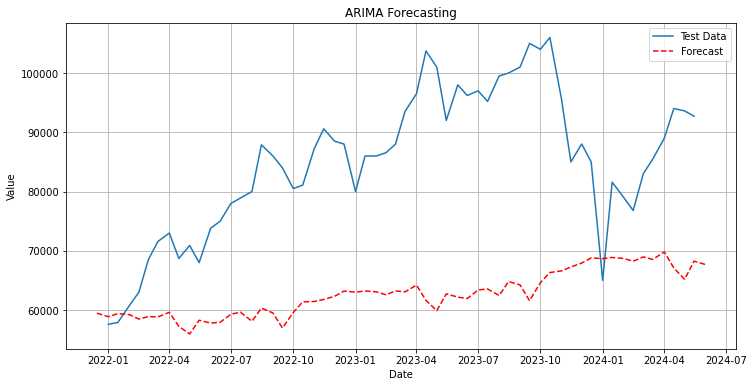

In [54]:
# Plotting
plt.figure(figsize=(12, 6), facecolor="white")
# plt.plot(train.index, train['Value'], label='Training Data')
plt.plot(test.index, test['Value'], label='Test Data')
plt.plot(pd.date_range(start = train.index[-1], periods=forecast_steps, freq="SMS"), forecast, label='Forecast', linestyle='--', color='r')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()